# Ensemble Model for Weather Forecasting

In [1]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')


# Data load And Analysis

In [70]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['Year'] = db.Date.dt.year
db['month'] = db.Date.dt.month


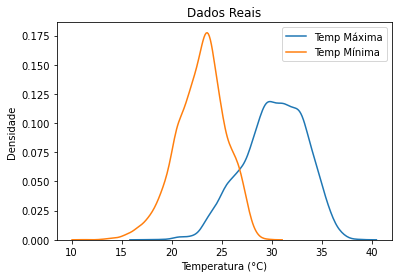

In [158]:
sns.distplot(db[['Next_Tmax']], hist=False, rug=False)
sns.distplot(db[['Next_Tmin']], hist=False,
             rug=False, axlabel='Temperatura (°C)')
plt.ylabel('Densidade')
plt.title('Dados Reais')
plt.legend(['Temp Máxima','Temp Mínima']) 


In [159]:
def tsplot(y, lags=None, title='' ,figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        ts_ax.set_xlabel('Lag')
        ts_ax.set_ylabel('Temperatura (°C)')
        acf_ax = plt.subplot2grid(layout, (1, 0))
        acf_ax.set_xlabel('Lag')
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        pacf_ax.set_xlabel('Lag')
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            'Análise Estacionaridade Temperatura {} \n Dickey-Fuller:'.format(title) + "p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


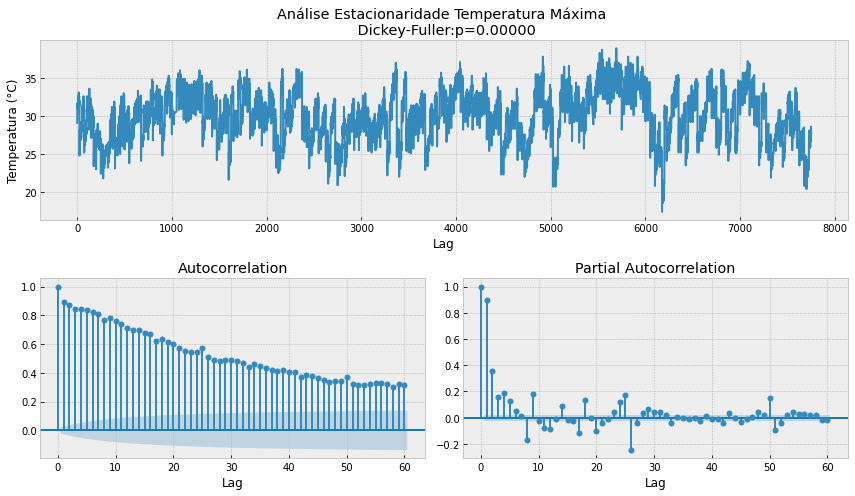

In [160]:
tsplot(db.Next_Tmax, lags=60,title='Máxima')


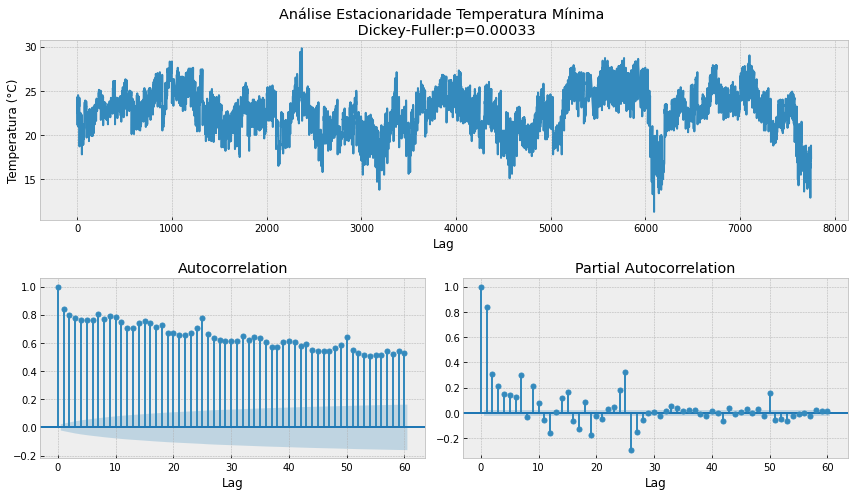

In [22]:
tsplot(db.Next_Tmin, lags=60,title='Mínima')

In [161]:
def plotMovingAverage(series, title,window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Média Móvel {} \n Janela = {}".format(title,window))
    plt.plot(rolling_mean, "g", label="Tendência")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Limites Superior/ Inferior")
        plt.plot(lower_bond, "r--")
        plt.xlabel('Data')
        plt.ylabel('Temperatura (°C)')

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(
                index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Valores Reais")
    plt.legend(loc="upper left")
    plt.grid(True)


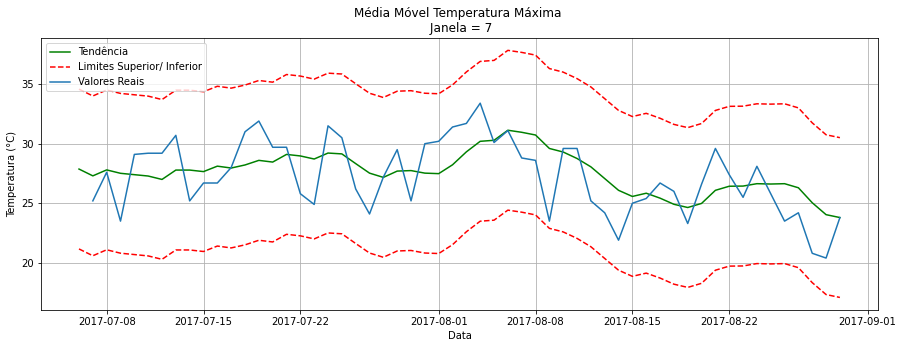

In [162]:
plotMovingAverage(db[(db.station==1)&(db.Year==2017)].set_index('Date')[['Next_Tmax']],'Temperatura Máxima',7,
                  plot_intervals=True, plot_anomalies=True)


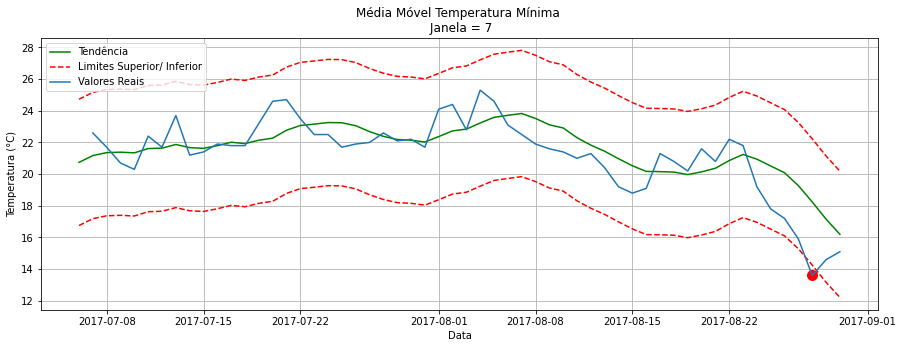

In [9]:
plotMovingAverage(db[(db.station == 1) & (db.Year == 2017)].set_index('Date')[['Next_Tmin']], 'Temperatura Mínima', 7,
                  plot_intervals=True, plot_anomalies=True)


## LDAPS Forecast Results Analysis

### All 25 Stations

In [71]:
import math
y_LDAPS_Tmax = db[db['Year']==2017]['LDAPS_Tmax_lapse']
yfit_LDAPS_max = db[db['Year'] == 2017]['Next_Tmax']
y_LDAPS_Tmin = db[db['Year'] == 2017]['LDAPS_Tmin_lapse']
yfit_LDAPS_min = db[db['Year'] == 2017]['Next_Tmin']
print("R-squared Tmax:",  r2_score(y_LDAPS_Tmax,
      yfit_LDAPS_max))
print("MSE Tmax:", math.sqrt(mean_squared_error(y_LDAPS_Tmax, yfit_LDAPS_max)))
print("R-squared Tmin:",  r2_score(y_LDAPS_Tmin,
      yfit_LDAPS_min))
print("MSE Tmin:", math.sqrt(mean_squared_error(y_LDAPS_Tmin, yfit_LDAPS_min)))


R-squared Tmax: 0.637651231066056
MSE Tmax: 1.8695680778823325
R-squared Tmin: 0.7476110528489134
MSE Tmin: 1.2310428117977916


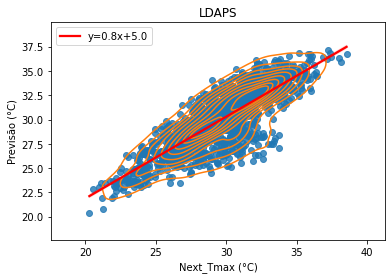

In [164]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_LDAPS_Tmax, yfit_LDAPS_max)
ax = sns.regplot(x=y_LDAPS_Tmax, y=yfit_LDAPS_max, line_kws={
                 'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_LDAPS_Tmax, yfit_LDAPS_max)
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmax (°C)', ylabel='Previsão (°C)', title='LDAPS')
ax.figure.savefig("LDAPS_tmax.jpeg")


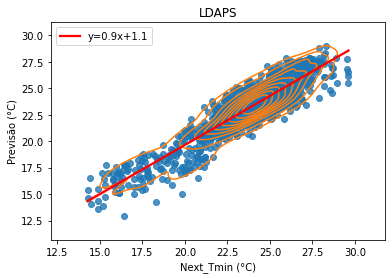

In [165]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_LDAPS_Tmin, yfit_LDAPS_min)
ax = sns.regplot(x=y_LDAPS_Tmin, y=yfit_LDAPS_min, line_kws={
                 'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_LDAPS_Tmin, yfit_LDAPS_min)
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='LDAPS')
ax.figure.savefig("LDAPS_tmin.jpeg")


### Unique Station

In [72]:
y_LDAPS_Tmax = db[(db['Year'] == 2017) & (
    db['station'] == 1)]['LDAPS_Tmax_lapse']
yfit_LDAPS_max = db[(db['Year'] == 2017) & (db['station'] == 1)]['Next_Tmax']
y_LDAPS_Tmin = db[(db['Year'] == 2017) & (
    db['station'] == 1)]['LDAPS_Tmin_lapse']
yfit_LDAPS_min = db[(db['Year'] == 2017) & (db['station'] == 1)]['Next_Tmin']
print("R-squared Tmax:",  r2_score(y_LDAPS_Tmax,
      yfit_LDAPS_max))
print("MSE Tmax:", math.sqrt(mean_squared_error(y_LDAPS_Tmax, yfit_LDAPS_max)))
print("R-squared Tmin:",  r2_score(y_LDAPS_Tmin,
      yfit_LDAPS_min))
print("MSE Tmin:", math.sqrt(mean_squared_error(y_LDAPS_Tmin, yfit_LDAPS_min)))


R-squared Tmax: 0.7215206452953711
MSE Tmax: 1.520968484199547
R-squared Tmin: 0.6890998231820646
MSE Tmin: 1.28324581123416


In [61]:
fig = px.line(db[(db['Year'] == 2017) & (db['station'] == 1)][['Date','LDAPS_Tmax_lapse', 'Next_Tmax']], x='Date', y=['Next_Tmax', 'LDAPS_Tmax_lapse'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo LDAPS (Temperatura Máxima T+1)', width=800, height=400)
fig.show()


In [63]:
fig = px.line(db[(db['Year'] == 2017) & (db['station'] == 1)][['Date', 'LDAPS_Tmin_lapse', 'Next_Tmin']], x='Date', y=['Next_Tmin', 'LDAPS_Tmin_lapse'], labels={
              'value': "Temperatura Mínima Seoul (°C)"}, title='Previsão Modelo LDAPS (Temperatura Mínima T+1)', width=800, height=400)
fig.show()


### Cross - Validation

In [69]:
years = [2017,2016,2015]
r2_list = []
mse_list = []
for year in years:
 y_LDAPS_Tmax = db[db['Year'] == year]['LDAPS_Tmax_lapse']
 yfit_LDAPS_max = db[db['Year'] == year]['Next_Tmax']
 mse_list.append(mean_squared_error(y_LDAPS_Tmax, yfit_LDAPS_max))
 r2_list.append(r2_score(y_LDAPS_Tmax,yfit_LDAPS_max))

np.array(mse_list).mean(),np.array(r2_list).mean()



(3.659685159143466, 0.606766387934356)

In [70]:
years = [2017, 2016, 2015]
r2_list = []
mse_list = []
for year in years:
 y_LDAPS_Tmin = db[db['Year'] == year]['LDAPS_Tmin_lapse']
 yfit_LDAPS_min = db[db['Year'] == year]['Next_Tmin']
 mse_list.append(mean_squared_error(y_LDAPS_Tmin, yfit_LDAPS_min))
 r2_list.append(r2_score(y_LDAPS_Tmin, yfit_LDAPS_min))

np.array(mse_list).mean(), np.array(r2_list).mean()


(1.6391480624113248, 0.7340910270727253)

# Data Engineering

#### Feature Creation

In [2]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['month'] = db.Date.dt.month
# db_aux2 = db.copy()
# db_aux2 = db_aux2.set_index(['station', 'Date'])
# db_aux2.sort_index(inplace=True)
# db_aux2['diffs'] = np.nan

# for idx in db_aux2.index.levels[0]:
#     db_aux2.diffs[idx] = db_aux2.LDAPS_Tmax_lapse[idx].diff().to_list()
# db_aux2.diffs = db_aux2.diffs.fillna(0)
# db_aux2 = db_aux2.reset_index()
db['LDAPS_LH_sqrt'] = db.LDAPS_LH**2
# Daily Cloud cover
db_aux = db.groupby(['station', 'month']).agg({"Present_Tmax": [
    "mean", "var"], "LDAPS_Tmax_lapse": ["mean", "var"]}).reset_index()

db = db.merge(db_aux, on=['station', 'month'], how='left')
# db = db.merge(db_aux2[['station', 'Date','diffs']], left_on=['station', 'Date'],right_on=['station', 'Date'], how='left')
#db = db.drop(['month'], axis=1)
db['Year'] = db.Date.dt.year
db = db.set_index(['station', 'Date', 'Year'])
db = db[(np.abs(stats.zscore(db)) < 5).all(axis=1)]
target = db[['Next_Tmax', 'Next_Tmin']]
features = db.drop(['Next_Tmax', 'Next_Tmin'], axis=1)



In [67]:
target.loc[pd.IndexSlice[:, :, [2017]]]['Next_Tmax'].std(), target.loc[pd.IndexSlice[:, :, [2017]]]['Next_Tmin'].std(),target.loc[pd.IndexSlice[[1], :, [2017]]]['Next_Tmax'].std(), target.loc[pd.IndexSlice[[1], :, [2017]]]['Next_Tmin'].std()


(3.1279549675658993, 2.5021730582647064, 2.9483534122229056, 2.264217371171734)

In [118]:
range(0, len(target.loc[pd.IndexSlice[:, :, [2017]]]
      ['Next_Tmax'].diff(14).abs()))


range(0, 1429)

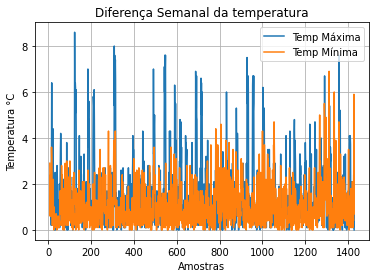

In [3]:
# temp_max_diff = []
# temp_min_diff = []
# for i in range(1,20):
#  temp_max_diff.append(target.loc[pd.IndexSlice[:, :, [2017]]]['Next_Tmax'].diff(i).abs().mean())
#  temp_min_diff.append(target.loc[pd.IndexSlice[:, :, [2017]]]['Next_Tmin'].diff(i).abs().mean())
a = range(0, len(target.loc[pd.IndexSlice[:, :, [2017]]]
                 ['Next_Tmax'].diff(7).abs()))
plt.plot(a, target.loc[pd.IndexSlice[:, :, [
         2017]]]['Next_Tmax'].diff(7).abs(), a, target.loc[pd.IndexSlice[:, :, [2017]]]['Next_Tmin'].diff(7).abs())
plt.grid()
plt.title('Diferença Semanal da temperatura')
plt.ylabel('Temperatura °C')
plt.xlabel('Amostras')
plt.legend(['Temp Máxima', 'Temp Mínima'])
plt.show()


In [4]:
z_score = pd.DataFrame(np.abs(stats.zscore(db)),columns=db.columns,index=db.index)
z_score[z_score>4].count().to_frame('Outliers')

,Outliers
Present_Tmax,0
Present_Tmin,2
LDAPS_RHmin,0
LDAPS_RHmax,1
LDAPS_Tmax_lapse,1
LDAPS_Tmin_lapse,0
LDAPS_WS,39
LDAPS_LH,0
LDAPS_CC1,0
LDAPS_CC2,0


#### Feature Correlation Analisys

<AxesSubplot:>

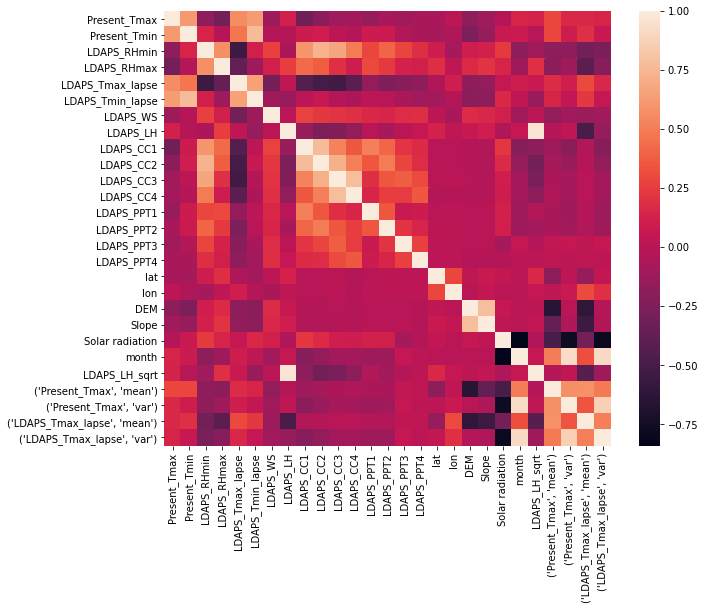

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(features.corr())


#### Data Transformation

In [6]:
x_scaler = StandardScaler()
norm_features = pd.DataFrame(x_scaler.fit_transform(features.values), columns=features.columns, index=features.index)
y_scaler_Tmax = StandardScaler()
y_scaler_fit_Tmax = y_scaler_Tmax.fit(
    np.array(target['Next_Tmax']).reshape(-1, 1))
target_norm_max = pd.DataFrame(y_scaler_Tmax.fit_transform(np.array(
    target['Next_Tmax']).reshape(-1, 1)), columns=target[['Next_Tmax']].columns, index=target[['Next_Tmax']].index)
y_scaler_Tmin = StandardScaler()
y_scaler_fit_Tmin = y_scaler_Tmin.fit(
    np.array(target['Next_Tmin']).reshape(-1, 1))
target_norm_Tmin = pd.DataFrame(y_scaler_Tmin.fit_transform(np.array(
    target['Next_Tmin']).reshape(-1, 1)), columns=target[['Next_Tmin']].columns, index=target[['Next_Tmin']].index)


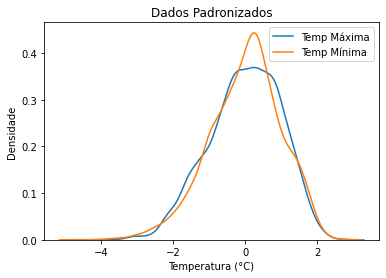

In [7]:
sns.distplot(target_norm_max[['Next_Tmax']], hist=False, rug=False)
sns.distplot(target_norm_Tmin[['Next_Tmin']],
             hist=False, rug=False, axlabel='Temperatura (°C)')
plt.ylabel('Densidade')
plt.title('Dados Padronizados')
plt.legend(['Temp Máxima', 'Temp Mínima'])


## Train And Test Split

In [10]:
X_train = norm_features.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]
X_test = norm_features.loc[pd.IndexSlice[:, :,[2017]], :]
y_train_Tmax = target_norm_max.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]['Next_Tmax']
y_test_Tmax =  target_norm_max.loc[pd.IndexSlice[:, :,[2017]], :]['Next_Tmax']
y_train_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]['Next_Tmin']
y_test_Tmin =  target_norm_Tmin.loc[pd.IndexSlice[:, :,[2017]], :]['Next_Tmin']

X_train_st1 = norm_features.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]
X_test_st1 = norm_features.loc[pd.IndexSlice[[1], :, [2017]], :]
y_train_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax']
y_train_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmin']


#### Feature Selection

In [11]:
X_train_2 = X_train.drop(['Present_Tmin', 'LDAPS_Tmin_lapse',
                          'DEM', 'LDAPS_CC1', 'LDAPS_RHmin', 'Solar radiation'], axis=1)
X_test_2 = X_test.drop(['Present_Tmin', 'LDAPS_Tmin_lapse',
                        'DEM', 'LDAPS_CC1', 'LDAPS_RHmin', 'Solar radiation'], axis=1)
X_test_st1_2 = X_test_st1.drop(['Present_Tmin', 'LDAPS_Tmin_lapse',
                                 'DEM', 'LDAPS_CC1', 'LDAPS_RHmin', 'Solar radiation'], axis=1)

X_train_st1_2 = X_train_st1.drop(['Present_Tmin', 'LDAPS_Tmin_lapse',
                                  'DEM', 'LDAPS_CC1', 'LDAPS_RHmin', 'Solar radiation'], axis=1)


# SVR Model

## Model Implementation For Tmax

### For all 25 Stations

In [29]:
progress = []
def evaluate(v):
    C,e = v
    model = SVR(C=C, epsilon=e)
    svr = model.fit(X_train, y_train_Tmax.ravel())
    yfit = svr.predict(X_test)
    progress.append(mean_squared_error(y_test_Tmax, yfit))
    return mean_squared_error(y_test_Tmax,yfit)


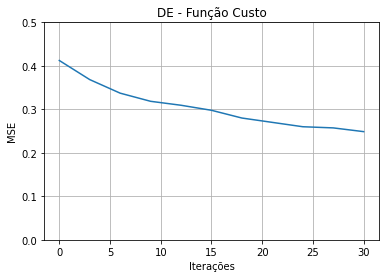

In [40]:
y = [0.41234,0.368374,0.337193, 0.318474,0.309373,0.297795,0.28,0.27,0.26,0.25732641,0.248723]
x = [0,3,6,9,12,15,18,21,24,27,30]
sns.lineplot(x,y)
plt.grid()
plt.ylim([0,0.5])
plt.title('DE - Função Custo')
plt.ylabel('MSE')
plt.xlabel('Iterações')
plt.show()

In [30]:
bounds = [[0.1,100],[0.0001,100]]
result = differential_evolution(evaluate, bounds, disp=True, maxiter=25)
result['x']


differential_evolution step 1: f(x)= 0.294462
differential_evolution step 2: f(x)= 0.294462
differential_evolution step 3: f(x)= 0.294462
differential_evolution step 4: f(x)= 0.294271
differential_evolution step 5: f(x)= 0.294271
differential_evolution step 6: f(x)= 0.294271
differential_evolution step 7: f(x)= 0.294262
differential_evolution step 8: f(x)= 0.294251


KeyboardInterrupt: 

In [12]:
model = SVR(C=49, epsilon=0.42)
svr_Tmax = model.fit(X_train_2,y_train_Tmax.ravel())
yfit = svr_Tmax.predict(X_test_2)
score = svr_Tmax.score(X_test_2,y_test_Tmax)
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y_scaler_fit_Tmax.inverse_transform(yfit)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),y_scaler_fit_Tmax.inverse_transform(yfit)))


R-squared: 0.6552676445131789
MSE: 3.370536305463435


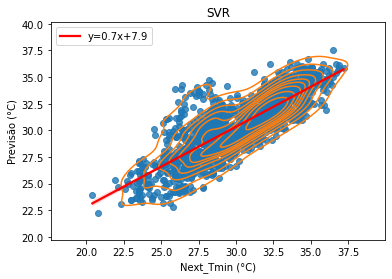

In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),y_scaler_fit_Tmax.inverse_transform(yfit))
ax = sns.regplot(x=y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y=y_scaler_fit_Tmax.inverse_transform(yfit),line_kws={'color': 'red','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
sns.kdeplot(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y_scaler_fit_Tmax.inverse_transform(yfit))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='SVR')
ax.figure.savefig("SVR_tmax.jpeg")

### Unique Station

In [14]:
yfit_st1 = svr_Tmax.predict(X_test_st1_2)
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1),y_scaler_fit_Tmax.inverse_transform(yfit_st1)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1), y_scaler_fit_Tmax.inverse_transform(yfit_st1)))


R-squared: 0.6787241553992226
MSE: 2.7454474553584705


In [15]:
y_test_Tmax_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmax_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1)
forecast_results = pd.merge(X_test_st1, y_test_Tmax_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(yfit_st1),columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()

,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,29.2000000000,28.0440398829
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,24.1000000000,25.8503746813
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,29.9000000000,27.6964732923
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,30.0000000000,29.1014533072
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,31.2000000000,31.1787320339


In [16]:
forecast_results.to_excel('svr_max.xlsx', index=False)

In [39]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax','Previsão'],labels={'value':"Temperatura Máxima Seoul (°C)"},title='Previsão Modelo SVR (Temperatura Máxima T+1)',width=800, height=400)
fig.show()

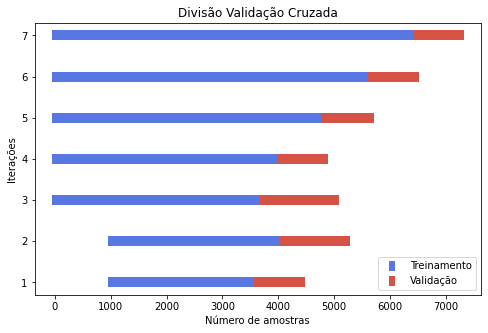

In [8]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=8)

fig, ax = plt.subplots(figsize=(8,5))
plt.yticks(range(0,10))
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
  if ii>0:
    if ii in [1,2,3]:
      tr = np.append(tr, np.arange(int(tr.max())+1,int(tr.max())+(2001/(ii+1)), 1))
      tt = np.arange(int(tr.max())+1,int(tt.max())+1001,1)
      if ii in [1,2]:
        #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
        tr = tr + 1000
        tt = tt +1000
      
    l1 = ax.scatter(tr, [ii]*len(tr),c=[plt.cm.coolwarm(.1)],marker='_',lw=10)
    l2 = ax.scatter(tt, [ii]*len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=10)
    ax.set(title='Divisão Validação Cruzada', xlabel='Número de amostras', ylabel='Iterações')
    ax.legend([l1,l2],['Treinamento','Validação'])


In [149]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
        if ii > 0:
        if ii in [1, 2, 3]:
        tr = np.append(tr, np.arange(
                int(tr.max())+1, int(tr.max())+(2001/(ii+1)), 1))
        tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
                #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
                tr = tr + 1000
                tt = tt + 1000
        X_train, X_test = norm_features.reset_index(drop=True).iloc[list(tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
        y_train, y_test = target_norm_max.reset_index(drop=True).iloc[list(tr)], target_norm_max.reset_index(drop=True).iloc[list(tt)]
        model = SVR(C=15, epsilon=0.06)
        svr_Tmax = model.fit(X_train, y_train['Next_Tmax'].ravel())
        yfit = svr_Tmax.predict(X_test)
        score = svr_Tmax.score(X_test, y_test['Next_Tmax'])
        print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test['Next_Tmax']),
                y_scaler_fit_Tmax.inverse_transform(yfit)))
        print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(
                y_test['Next_Tmax']), y_scaler_fit_Tmax.inverse_transform(yfit)))


R-squared: 0.6873267430170527
MSE: 3.9799914790116775
R-squared: 0.6735998034610733
MSE: 3.159559975947182
R-squared: 0.6854327567365277
MSE: 3.871399711473888
R-squared: 0.6956268945164332
MSE: 3.3597958579604925


## Model Implementation for Tmin

In [29]:
def evaluate(v):
    C,e = v
    model = SVR(C=C, epsilon=e)
    svr = model.fit(X_train, y_train_Tmin.ravel())
    yfit = svr.predict(X_test)
    return mean_squared_error(y_test_Tmin,yfit)

In [1]:
bounds = [[0.1,15],[0.0001,1]]
result = differential_evolution(evaluate, bounds, disp=True, maxiter=5)
result['x']

NameError: name 'differential_evolution' is not defined

In [17]:
model = SVR(C=1.0859, epsilon=0.4811)
svr_Tmin = model.fit(X_train,y_train_Tmin.ravel())
yfit_Tmin = svr_Tmin.predict(X_test)
score = svr_Tmin.score(X_test,y_test_Tmin)
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmin), y_scaler_fit_Tmax.inverse_transform(yfit_Tmin)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmin),y_scaler_fit_Tmax.inverse_transform(yfit_Tmin)))


R-squared: 0.8248765403885204
MSE: 1.6615391642197885


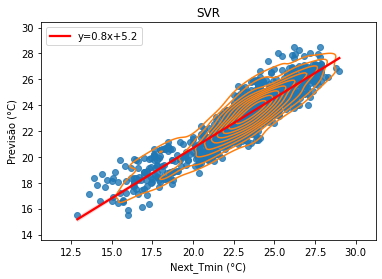

In [18]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y_scaler_fit_Tmin.inverse_transform(yfit_Tmin))
ax = sns.regplot(x=y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y=y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin),
            y_scaler_fit_Tmin.inverse_transform(yfit_Tmin))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='SVR')
ax.figure.savefig("SVR_tmin.jpeg")


### Unique Station

In [19]:
yfit_st1 = svr_Tmin.predict(X_test_st1)
print("R-squared:",  r2_score(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1),y_scaler_fit_Tmin.inverse_transform(yfit_st1)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1), y_scaler_fit_Tmin.inverse_transform(yfit_st1)))


R-squared: 0.7990477247307706
MSE: 1.0127567484015303


In [46]:
y_test_Tmin_st1_frame = y_test_Tmin_st1.to_frame('Next_Tmin')
y_test_Tmin_st1_frame['Next_Tmin'] = y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1)
forecast_results = pd.merge(X_test, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmin.inverse_transform(yfit_st1), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,29.2000000000,27.1887591130
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,24.1000000000,27.6016255711
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,29.9000000000,27.0360995078
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,30.0000000000,28.5593982244
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,31.2000000000,28.9461860697


In [21]:
forecast_results.to_excel('svr_min.xlsx', index=False)


In [45]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin','Previsão'],labels={'value':"Temperatura Mínima Seoul (°C)"},title='Previsão Modelo SVR (Temperatura Mínima T+1)',width=800, height=400)
fig.show()

### CROSS VALIDATION

In [13]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
      if ii > 0:
        if ii in [1, 2, 3]:
          tr = np.append(tr, np.arange(int(tr.max())+1,
                        int(tr.max())+(2001/(ii+1)), 1))
          tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
          #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
          tr = tr + 1000
          tt = tt + 1000
      X_train, X_test = norm_features.reset_index(drop=True).iloc[list(
              tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
      y_train, y_test = target_norm_Tmin.reset_index(drop=True).iloc[list(
              tr)], target_norm_Tmin.reset_index(drop=True).iloc[list(tt)]
      model = SVR(C=1.0859, epsilon=0.4811)
      svr_Tmax = model.fit(X_train, y_train['Next_Tmin'].ravel())
      yfit = svr_Tmax.predict(X_test)
      score = svr_Tmax.score(X_test, y_test['Next_Tmin'])
      print("R-squared:",  r2_score(y_scaler_fit_Tmin.inverse_transform(y_test['Next_Tmin']),
                                    y_scaler_fit_Tmin.inverse_transform(yfit)))
      print("MSE:", mean_squared_error(y_scaler_fit_Tmin.inverse_transform(
          y_test['Next_Tmin']), y_scaler_fit_Tmin.inverse_transform(yfit)))


R-squared: 0.5347061062715637
MSE: 2.447216852467081
R-squared: 0.7762383496620964
MSE: 1.2148323656902538
R-squared: 0.6971710178434943
MSE: 1.9145680521582265
R-squared: 0.7460480650179415
MSE: 1.4009590353988084
R-squared: 0.6904051075174105
MSE: 1.122003543482393
R-squared: -0.11571192574853661
MSE: 2.50675638255893
R-squared: 0.6839401919093641
MSE: 2.5583594187848346
R-squared: 0.8472283009775599
MSE: 1.305391472936347


# MLP Model

## Model Implementation for Tmax

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout	
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### All 25 stations

In [48]:
n_input = len(X_train_2.columns)
model = Sequential()
model.add(Dense(80, activation='relu', input_shape=(n_input,)))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001, verbose=1)
earlyStopping = EarlyStopping(
    monitor='val_loss', patience=100, verbose=0, mode='min')
mcp_save = ModelCheckpoint(
    '.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train_2, y_train_Tmax, epochs=150, verbose=1,
                    callbacks=[reduce_lr, earlyStopping, mcp_save], shuffle=True, validation_data=(X_test_2, y_test_Tmax))
yfit_Tmax_mlp = model.predict(X_test_2)
print("R-squared:",  r2_score(y_test_Tmax,yfit_Tmax_mlp))
print("MSE:", mean_squared_error(y_test_Tmax,yfit_Tmax_mlp))


Epoch 1/150
183/183 [==============================] - 2s 5ms/step - loss: 0.7429 - accuracy: 0.0000e+00 - val_loss: 0.3571 - val_accuracy: 0.0000e+00
Epoch 2/150
183/183 [==============================] - 0s 2ms/step - loss: 0.3800 - accuracy: 0.0000e+00 - val_loss: 0.3286 - val_accuracy: 0.0000e+00
Epoch 3/150
183/183 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.0000e+00 - val_loss: 0.3256 - val_accuracy: 0.0000e+00
Epoch 4/150
183/183 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.0000e+00 - val_loss: 0.3408 - val_accuracy: 0.0000e+00
Epoch 5/150
183/183 [==============================] - 0s 2ms/step - loss: 0.2496 - accuracy: 0.0000e+00 - val_loss: 0.3407 - val_accuracy: 0.0000e+00
Epoch 6/150
183/183 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.0000e+00 - val_loss: 0.3486 - val_accuracy: 0.0000e+00
Epoch 7/150
183/183 [==============================] - 1s 3ms/step - loss: 0.2210 - accuracy: 

In [14]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

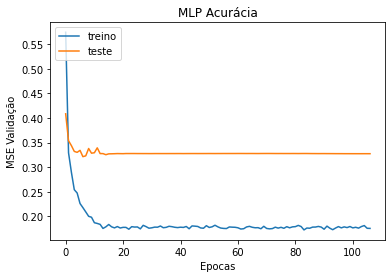

In [32]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP Acurácia')
plt.ylabel('MSE Validação')
plt.xlabel('Epocas')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

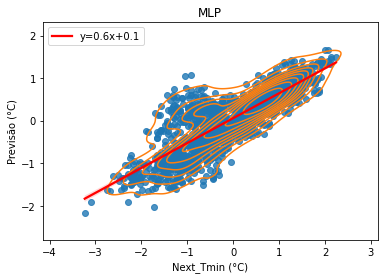

In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_Tmax,yfit_Tmax_mlp.flatten())
ax = sns.regplot(x=y_test_Tmax, y= yfit_Tmax_mlp.flatten(), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_test_Tmax,yfit_Tmax_mlp.flatten())
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='MLP')
ax.figure.savefig("MLP_tmax.jpeg")


### Unique Station

In [50]:
yfit_Tmax_mlp = model.predict(X_test_st1_2)
print("R-squared:",  r2_score(y_test_Tmax_st1,yfit_Tmax_mlp))
print("MSE:", mean_squared_error(y_test_Tmax_st1,yfit_Tmax_mlp))


R-squared: 0.6292370760281216
MSE: 0.33611869279597384


In [51]:
y_test_Tmax_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmax_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(
    y_test_Tmax_st1)
forecast_results = pd.merge(
    X_test_st1, y_test_Tmax_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(
    yfit_st1), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,29.2000000000,27.1887591130
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,24.1000000000,27.6016255711
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,29.9000000000,27.0360995078
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,30.0000000000,28.5593982244
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,31.2000000000,28.9461860697


In [54]:

forecast_results.to_excel('mlp_max.xlsx', index=False)


In [55]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo MLP (Temperatura Máxima T+1)', width=800, height=400)
fig.show()


In [18]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
      if ii > 0:
        if ii in [1, 2, 3]:
          tr = np.append(tr, np.arange(int(tr.max())+1,
                                        int(tr.max())+(2001/(ii+1)), 1))
          tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
          #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
          tr = tr + 1000
          tt = tt + 1000
      X_train, X_test = norm_features.reset_index(drop=True).iloc[list(tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
      y_train, y_test = target_norm_max.reset_index(drop=True).iloc[list(tr)], target_norm_max.reset_index(drop=True).iloc[list(tt)]
      n_input = len(X_train.columns)
      model = Sequential()
      model.add(Dense(80, activation='relu', input_shape=(n_input,)))
      model.add(Dropout(0.25))
      model.add(Dense(10, activation='relu'))
      model.add(Dropout(0.25))
      model.add(Dense(10, activation='relu'))
      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
      reduce_lr = ReduceLROnPlateau(
          monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001, verbose=1)
      earlyStopping = EarlyStopping(
          monitor='val_loss', patience=100, verbose=0, mode='min')
      mcp_save = ModelCheckpoint(
          '.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
      history = model.fit(X_train, y_train, epochs=150, verbose=1,
                          callbacks=[reduce_lr, earlyStopping, mcp_save], shuffle=True, validation_data=(X_test, y_test))
      yfit_Tmax_mlp = model.predict(X_test)
      print("R-squared:",  r2_score(y_test,yfit_Tmax_mlp))
      print("MSE:", mean_squared_error(y_test,yfit_Tmax_mlp))


Epoch 1/150
26/26 [==============================] - 2s 15ms/step - loss: 1.0536 - accuracy: 0.0000e+00 - val_loss: 0.6224 - val_accuracy: 0.0000e+00
Epoch 2/150
26/26 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.0000e+00 - val_loss: 0.4926 - val_accuracy: 0.0000e+00
Epoch 3/150
26/26 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.0000e+00 - val_loss: 0.4208 - val_accuracy: 0.0000e+00
Epoch 4/150
26/26 [==============================] - 0s 3ms/step - loss: 0.3137 - accuracy: 0.0000e+00 - val_loss: 0.3647 - val_accuracy: 0.0000e+00
Epoch 5/150
26/26 [==============================] - 0s 3ms/step - loss: 0.3151 - accuracy: 0.0000e+00 - val_loss: 0.3507 - val_accuracy: 0.0000e+00
Epoch 6/150
26/26 [==============================] - 0s 5ms/step - loss: 0.2636 - accuracy: 0.0000e+00 - val_loss: 0.3385 - val_accuracy: 0.0000e+00
Epoch 7/150
26/26 [==============================] - 0s 3ms/step - loss: 0.2727 - accuracy: 0.0000e+00 - 

In [19]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
      if ii > 0:
        if ii in [1, 2, 3]:
          tr = np.append(tr, np.arange(int(tr.max())+1,
                                       int(tr.max())+(2001/(ii+1)), 1))
          tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
          #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
          tr = tr + 1000
          tt = tt + 1000
      X_train, X_test = norm_features.reset_index(drop=True).iloc[list(
            tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
      y_train, y_test = target_norm_Tmin.reset_index(drop=True).iloc[list(
            tr)], target_norm_Tmin.reset_index(drop=True).iloc[list(tt)]
      n_input = len(X_train.columns)
      model = Sequential()
      model.add(Dense(80, activation='relu', input_shape=(n_input,)))
      model.add(Dropout(0.25))
      model.add(Dense(10, activation='relu'))
      model.add(Dropout(0.25))
      model.add(Dense(10, activation='relu'))
      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
      reduce_lr = ReduceLROnPlateau(
          monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001, verbose=1)
      earlyStopping = EarlyStopping(
          monitor='val_loss', patience=100, verbose=0, mode='min')
      mcp_save = ModelCheckpoint(
          '.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
      history = model.fit(X_train, y_train, epochs=150, verbose=1,
                          callbacks=[reduce_lr, earlyStopping, mcp_save], shuffle=True, validation_data=(X_test, y_test))
      yfit_Tmax_mlp = model.predict(X_test)
      print("R-squared:",  r2_score(y_test, yfit_Tmax_mlp))
      print("MSE:", mean_squared_error(y_test, yfit_Tmax_mlp))


Epoch 1/150
26/26 [==============================] - 2s 17ms/step - loss: 0.4917 - accuracy: 0.0000e+00 - val_loss: 0.8124 - val_accuracy: 0.0000e+00
Epoch 2/150
26/26 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.0000e+00 - val_loss: 0.6917 - val_accuracy: 0.0000e+00
Epoch 3/150
26/26 [==============================] - 0s 3ms/step - loss: 0.2804 - accuracy: 0.0000e+00 - val_loss: 0.6201 - val_accuracy: 0.0000e+00
Epoch 4/150
26/26 [==============================] - 0s 3ms/step - loss: 0.2262 - accuracy: 0.0000e+00 - val_loss: 0.5609 - val_accuracy: 0.0000e+00
Epoch 5/150
26/26 [==============================] - 0s 3ms/step - loss: 0.2011 - accuracy: 0.0000e+00 - val_loss: 0.5573 - val_accuracy: 0.0000e+00
Epoch 6/150
26/26 [==============================] - 0s 4ms/step - loss: 0.1883 - accuracy: 0.0000e+00 - val_loss: 0.5217 - val_accuracy: 0.0000e+00
Epoch 7/150
26/26 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.0000e+00 - 

## Model Implementation for Tmin

In [56]:
n_input = len(X_train.columns)
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(n_input,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train_Tmin, epochs=1000, verbose=0)
yfit_Tmin_mlp = model.predict(X_test)
print("R-squared:",  r2_score(y_test_Tmin,yfit_Tmin_mlp))
print("MSE:", mean_squared_error(y_test_Tmin,yfit_Tmin_mlp))


R-squared: 0.7506397990843184
MSE: 0.25098900595327406


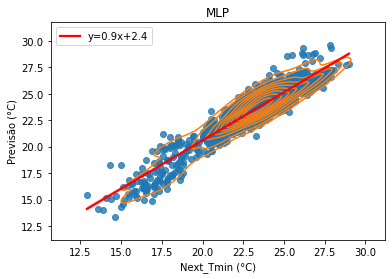

In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_Tmin, yfit_Tmin_mlp.flatten())
ax = sns.regplot(x=y_test_Tmin, y=yfit_Tmin_mlp.flatten(), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_test_Tmin, yfit_Tmin_mlp.flatten())
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='MLP')
ax.figure.savefig("MLP_tmax.jpeg")


### Unique Station

In [57]:
yfit_Tmin_mlp = model.predict(X_test_st1)
print("R-squared:",  r2_score(y_test_Tmin_st1, yfit_Tmin_mlp))
print("MSE:", mean_squared_error(y_test_Tmin_st1, yfit_Tmin_mlp))


R-squared: 0.8281034690600358
MSE: 0.13937222189083728


In [58]:
y_test_Tmin_st1_frame = y_test_Tmin_st1.to_frame('Next_Tmin')
y_test_Tmin_st1_frame['Next_Tmin'] = y_scaler_fit_Tmin.inverse_transform(
    y_test_Tmin_st1)
forecast_results = pd.merge(
    X_test, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmin.inverse_transform(
    yfit_st1), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmin,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,19.6000000000,20.3853391760
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.4000000000,20.7206069473
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.6000000000,20.2613721048
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.5000000000,21.4983652186
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,21.5000000000,21.8124558799


In [59]:
forecast_results.to_excel('mlp_min.xlsx', index=False)


In [60]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin', 'Previsão'], labels={'value': 'Temperatura Minima Seoul (°C)'}, title='Previsão Modelo MLP (Temperatura Mínima T+1)', width=800, height=400)
fig.show()


# Random Forest

## Model Implementation fo Tmax

### For all 25 stations Model Parametrization Analysis

In [32]:
from sklearn.ensemble import RandomForestRegressor


In [82]:
results = []
for i in range(1,2000,50):
 regressor = RandomForestRegressor(
     n_estimators=i, criterion='mse', random_state=0, verbose=1, oob_score=True, n_jobs=-1)
 regressor.fit(X_train, y_train_Tmax)
 yfit_Tmax_RF = regressor.predict(X_test)
 results.append(r2_score(y_test_Tmax, yfit_Tmax_RF))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [64]:
np.array(results)

array([0.40951844, 0.63158021, 0.6357197 , 0.63603281, 0.63863343,
       0.63920785, 0.63839161, 0.63949429, 0.63931038, 0.63839674,
       0.63925925, 0.63938935, 0.63990288, 0.64020029, 0.63996191,
       0.6401886 , 0.64004171, 0.64043383, 0.64023477, 0.64047063,
       0.6401186 , 0.6399672 , 0.63982492, 0.64004601, 0.64000041,
       0.64032956, 0.64040253, 0.64031672, 0.64014994, 0.64000152,
       0.64021079, 0.6403317 , 0.64031179, 0.64033904, 0.64034287,
       0.64047094, 0.6404226 , 0.64045134, 0.64048932, 0.64047343])

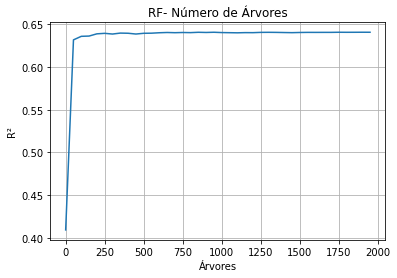

In [10]:
y = np.array(results)
x = range(1,2000,50)
plt.plot(x, y)
plt.grid()
plt.title('RF- Número de Árvores')
plt.ylabel('R²')
plt.xlabel('Árvores')
plt.show()


In [33]:
regressor = RandomForestRegressor(
    n_estimators=500, criterion='mse', random_state=0, verbose=1, oob_score=True, n_jobs=-1)
regressor.fit(X_train, y_train_Tmax)
yfit_Tmax_RF = regressor.predict(X_test)
print("R-squared:", r2_score(y_test_Tmax, yfit_Tmax_RF))
print("MSE:", mean_squared_error(y_test_Tmax, yfit_Tmax_RF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


R-squared: 0.6392413363738263
MSE: 0.374192464323779


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


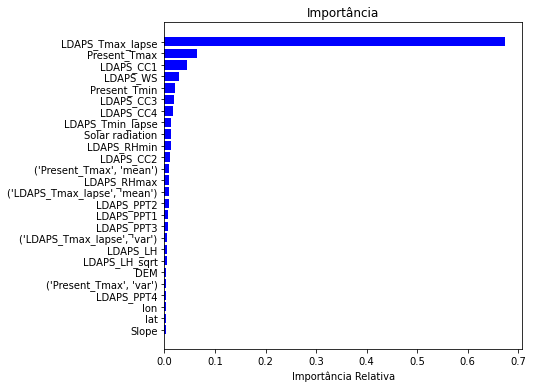

In [54]:
importances = regressor.feature_importances_
indices = np.argsort(importances)
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Importância')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()


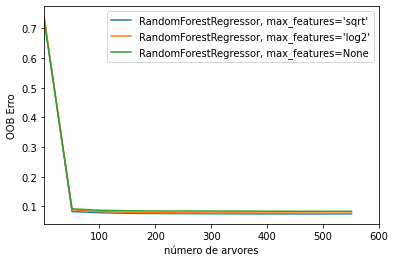

In [9]:
from collections import OrderedDict
ensemble_clfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            warm_start=False,
            oob_score=True,
            max_features="sqrt",
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            warm_start=False,
            max_features="log2",
            oob_score=True,
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            warm_start=False,
            max_features=None,
            oob_score=True,
            random_state=0,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)


for label, clf in ensemble_clfs:
    for i in range(1, 600, 50):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train_Tmax)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(1, 600)
plt.xlabel("número de arvores")
plt.ylabel("OOB Erro")
plt.legend(loc="upper right")
plt.show()


### Tmax Forecast

In [34]:
regressor = RandomForestRegressor(n_estimators=500, criterion='mse', random_state=0,verbose=1,oob_score=True,n_jobs=-1)
regressor.fit(X_train, y_train_Tmax)
yfit_Tmax_RF = regressor.predict(X_test)
print("R-squared:", r2_score(y_test_Tmax, yfit_Tmax_RF))
print("MSE:", mean_squared_error(y_test_Tmax, yfit_Tmax_RF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.0s finished


R-squared: 0.6392413363738263
MSE: 0.374192464323779


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


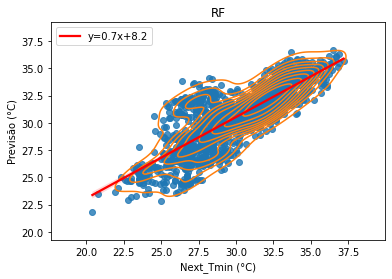

In [22]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_RF))
ax = sns.regplot(x=y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y=y_scaler_fit_Tmax.inverse_transform(
    yfit_Tmax_RF), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
            y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_RF))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='RF')
ax.figure.savefig("RF_tmax.jpeg")


In [35]:
yfit_RF = regressor.predict(X_test_st1)
print("R-squared:", r2_score(y_test_Tmax_st1, yfit_RF))
print("MSE:", mean_squared_error(y_test_Tmax_st1, yfit_RF))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


R-squared: 0.6967876905850461
MSE: 0.2748800338189499


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


In [36]:
y_test_Tmax_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmax_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(
    y_test_Tmax_st1)
forecast_results = pd.merge(
    X_test_st1, y_test_Tmax_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(
    yfit_RF), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,29.2000000000,27.3524000000
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,24.1000000000,23.8926000000
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,29.9000000000,28.2766000000
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,30.0000000000,29.8056000000
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,31.2000000000,31.6304000000


In [37]:
forecast_results.to_excel('RF_max.xlsx', index=False)


In [25]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo RF (Temperatura Máxima T+1)', width=800, height=400)
fig.show()


### Model Implementation For Tmin

In [38]:
regressor = RandomForestRegressor(
    n_estimators=500, criterion='mse', random_state=0, verbose=1, oob_score=True, n_jobs=-1)
regressor.fit(X_train, y_train_Tmin)
yfit_Tmin_RF = regressor.predict(X_test)
print("R-squared:", r2_score(y_test_Tmin, yfit_Tmin_RF))
print("MSE:", mean_squared_error(y_test_Tmin, yfit_Tmin_RF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.5s finished


R-squared: 0.8738081774713846
MSE: 0.12701609952022347


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


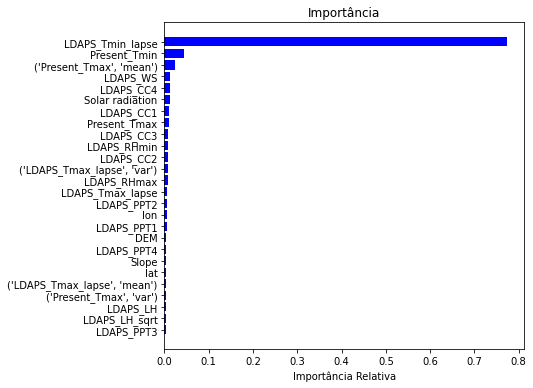

In [12]:
importances = regressor.feature_importances_
indices = np.argsort(importances)
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Importância')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()


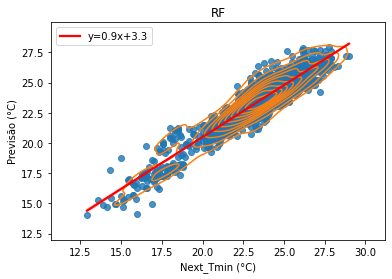

In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y_scaler_fit_Tmin.inverse_transform(yfit_Tmin_RF))
ax = sns.regplot(x=y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y=y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin_RF), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin),
            y_scaler_fit_Tmin.inverse_transform(yfit_Tmin_RF))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='RF')
ax.figure.savefig("RF_tmin.jpeg")


In [40]:
yfit_Tmin_RF = regressor.predict(X_test_st1)
print("R-squared:", r2_score(y_test_Tmin_st1, yfit_Tmin_RF))
print("MSE:", mean_squared_error(y_test_Tmin_st1, yfit_Tmin_RF))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


R-squared: 0.9079342887998404
MSE: 0.0746460830812684


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


In [41]:
y_test_Tmin_st1_frame = y_test_Tmin_st1.to_frame('Next_Tmin')
y_test_Tmin_st1_frame['Next_Tmin'] = y_scaler_fit_Tmin.inverse_transform(
    y_test_Tmin_st1)
forecast_results = pd.merge(
    X_test_st1, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin_RF), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,Slope,Solar radiation,month,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmin,Previsão
0,1.0000000000,2017-06-30,2017,-0.6447929063,-1.3699559424,0.1941900929,1.3429294974,-1.0031677778,-1.1493204365,-0.2993557589,...,1.1202599602,1.5231812846,-2.8103625552,0.1307588539,-3.9154891057,-2.3610403483,-3.3176454862,-1.1261880343,19.6000000000,19.7850000000
1,1.0000000000,2017-07-01,2017,-0.2055854700,-1.4115527052,2.4417765029,1.6437432168,-1.8456171694,-0.3968809399,1.0771214951,...,1.1202599602,1.5111052415,-0.9008617039,-0.9636300126,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.4000000000,21.1786000000
2,1.0000000000,2017-07-03,2017,-1.6245633413,-1.1203753652,0.2147222339,1.1737220433,-0.1572638938,-0.7698342007,0.1086494035,...,1.1202599602,1.4830158852,-0.9008617039,1.9129437623,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.6000000000,20.4402000000
3,1.0000000000,2017-07-04,2017,-0.4082965945,-0.5796174481,-0.3446554442,0.0452107530,-0.0308315587,-0.4685306531,-0.3013667209,...,1.1202599602,1.4669980143,-0.9008617039,1.7920016000,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,20.5000000000,21.0384000000
4,1.0000000000,2017-07-05,2017,-0.2055854700,-1.0371818395,0.0979264934,0.0838965278,0.6256978708,-0.3807260688,0.1554606090,...,1.1202599602,1.4496635440,-0.9008617039,1.5148983035,-3.5709547630,-1.1435850016,-2.1832934416,-1.0310617596,21.5000000000,21.4296000000


In [42]:
forecast_results.to_excel('RF_min.xlsx', index=False)


In [56]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo RF (Temperatura Mínima T+1)', width=800, height=400)
fig.show()


In [22]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
      if ii > 0:
        if ii in [1, 2, 3]:
          tr = np.append(tr, np.arange(int(tr.max())+1,
                                       int(tr.max())+(2001/(ii+1)), 1))
          tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
          #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
          tr = tr + 1000
          tt = tt + 1000
      X_train, X_test = norm_features.reset_index(drop=True).iloc[list(
          tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
      y_train, y_test = target_norm_max.reset_index(drop=True).iloc[list(
          tr)], target_norm_max.reset_index(drop=True).iloc[list(tt)]
      regressor = RandomForestRegressor(
          n_estimators=500, criterion='mse', random_state=0, verbose=1, oob_score=True, n_jobs=-1)
      regressor.fit(X_train, y_train)
      yfit_Tmax_RF = regressor.predict(X_test)
      print("R-squared:", r2_score(y_test, yfit_Tmax_RF))
      print("MSE:", mean_squared_error(y_test, yfit_Tmax_RF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.53696416691757
MSE: 0.2896317664123874


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.44606003423313234
MSE: 0.33449433467414996


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.7486135617536782
MSE: 0.26170737232189034


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.6427992915244942
MSE: 0.32097696203386666


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.821045951466647
MSE: 0.17928241335349224


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.3728229566681873
MSE: 0.3041771829444754


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.7304284905334286
MSE: 0.3359773380425634


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.0s finished


R-squared: 0.7111293937633967
MSE: 0.3395266524123303


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [23]:
for ii, (tr, tt) in enumerate(cv.split(norm_features, target_norm_max)):
      if ii > 0:
        if ii in [1, 2, 3]:
          tr = np.append(tr, np.arange(int(tr.max())+1,
                                       int(tr.max())+(2001/(ii+1)), 1))
          tt = np.arange(int(tr.max())+1, int(tt.max())+1001, 1)
        if ii in [1, 2]:
          #tt = np.arange(int(tr.max())+1, int(tt.max())+500, 1)
          tr = tr + 1000
          tt = tt + 1000
      X_train, X_test = norm_features.reset_index(drop=True).iloc[list(
          tr)], norm_features.reset_index(drop=True).iloc[list(tt)]
      y_train, y_test = target_norm_Tmin.reset_index(drop=True).iloc[list(
          tr)], target_norm_Tmin.reset_index(drop=True).iloc[list(tt)]
      regressor = RandomForestRegressor(
          n_estimators=500, criterion='mse', random_state=0, verbose=1, oob_score=True, n_jobs=-1)
      regressor.fit(X_train, y_train)
      yfit_Tmax_RF = regressor.predict(X_test)
      print("R-squared:", r2_score(y_test, yfit_Tmax_RF))
      print("MSE:", mean_squared_error(y_test, yfit_Tmax_RF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.716271578455603
MSE: 0.24007383888566375


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.780405359992332
MSE: 0.1918003195347598


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.8218252180026793
MSE: 0.1812243290257851


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.784186245097543
MSE: 0.19153578448390066


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.7597069743873482
MSE: 0.1401001178142298


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.2442702910022121
MSE: 0.27316398711197387


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


R-squared: 0.8633370193086967
MSE: 0.1779672410157442


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.0s finished


R-squared: 0.901312587821438
MSE: 0.13566146956770075


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
